# Project Name: Weather Pattern Analysis & Dimensionality Reduction Using PCA on Szeged Climate Data

## Overview
A meteorological research institute wants to understand the underlying weather patterns and climate drivers in Szeged, Hungary to improve forecasting models and identify key environmental factors.

## You have:
● **Hourly weather measurements**: temperature, apparent temperature, humidity, wind speed, wind bearing, visibility, pressure, etc.
● **Weather conditions**: precipitation type, cloud cover, weather summaries, and daily descriptions  
● **Time-series data**: spanning multiple years with consistent hourly observations from 2006 onwards

## We will:
1. Explore and visualize weather feature distributions using histograms and statistical summaries to understand data characteristics.
2. Apply Principal Component Analysis (PCA) with proper data preprocessing (standardization, missing value handling) to reduce dimensionality and identify main weather variation patterns.
3. Analyze component loadings to determine which weather features contribute most significantly to climate variability in Szeged.
4. Create scree plots and variance analysis to determine optimal number of components for capturing weather patterns.
5. Visualize the reduced-dimension weather data in 2D space with color-coding by temperature and other key variables.

## Goal
Climate researchers and meteorologists can use these insights to understand the primary drivers of weather variation, simplify complex weather models, identify unusual weather patterns, and focus monitoring efforts on the most influential atmospheric variables for improved forecasting accuracy.


In [1]:
import pandas as pd          
import numpy as np            
import matplotlib.pyplot as plt  
import seaborn as sns        
from sklearn.decomposition import PCA        
from sklearn.preprocessing import StandardScaler  
from sklearn.impute import SimpleImputer
import base64
from IPython.display import display, HTML
import os
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 6)  
plt.rcParams['font.size'] = 12             
sns.set_palette("husl")                    

pd.set_option('display.max_columns', None)


#### Notebook utility

In [2]:
image_paths = ["PCA_gif.gif", "PCA1.png", "PCA3.png", "PCA4.webp", "PCA5.webp", "PCA6.png"]
image_size = [1000, 700, 400, 600, 500, 500, 500, 500]
images_html = []

mime_map = {
    ".png": "image/png",
    ".jpg": "image/jpeg",
    ".jpeg": "image/jpeg",
    ".gif": "image/gif",
    ".webp": "image/webp"
}

for i, path in enumerate(image_paths):
    ext = os.path.splitext(path)[1].lower()
    mime = mime_map.get(ext, "image/png")

    with open("../img/"+path, "rb") as f:
        data = f.read()
    encoded = base64.b64encode(data).decode("utf-8")

    img_tag = f'<img src="data:{mime};base64,{encoded}" style="display: block; margin-left: auto; margin-right: auto; width: {image_size[i]}px;" /><br>'
    images_html.append(img_tag)


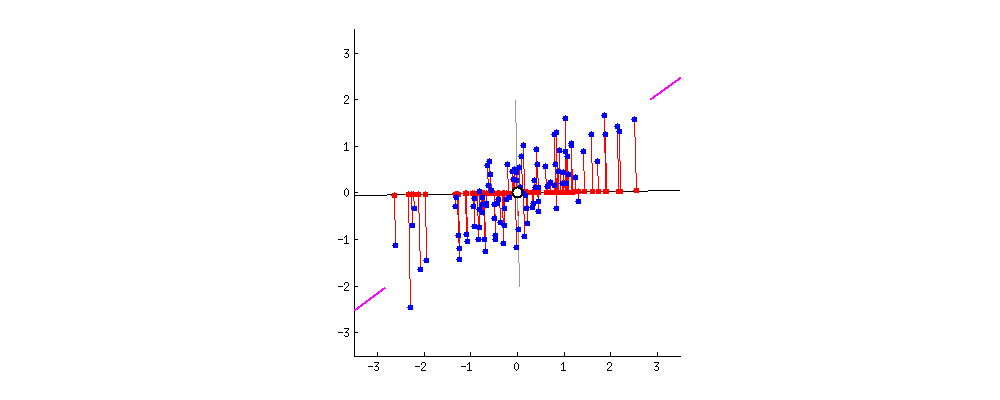

In [3]:
display(HTML(images_html[0]))


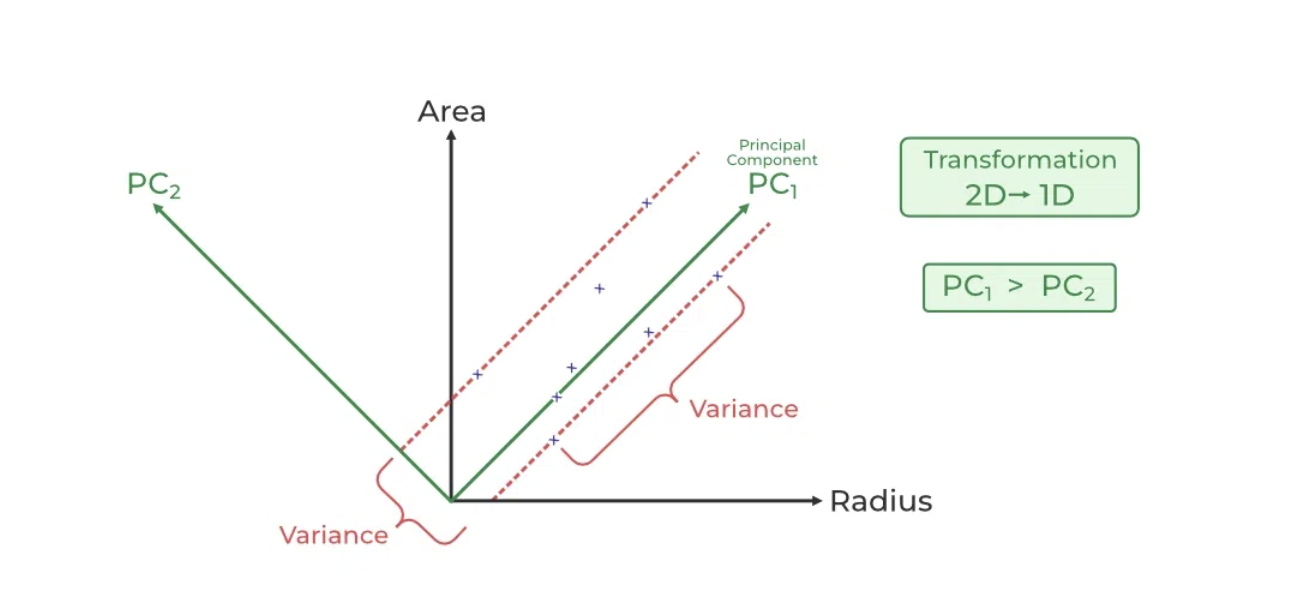

In [4]:
display(HTML(images_html[1]))


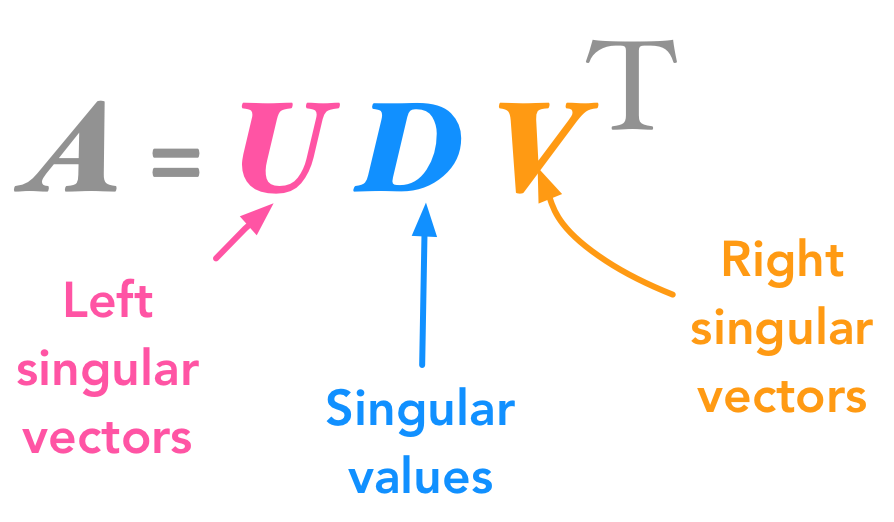

In [5]:
display(HTML(images_html[2]))


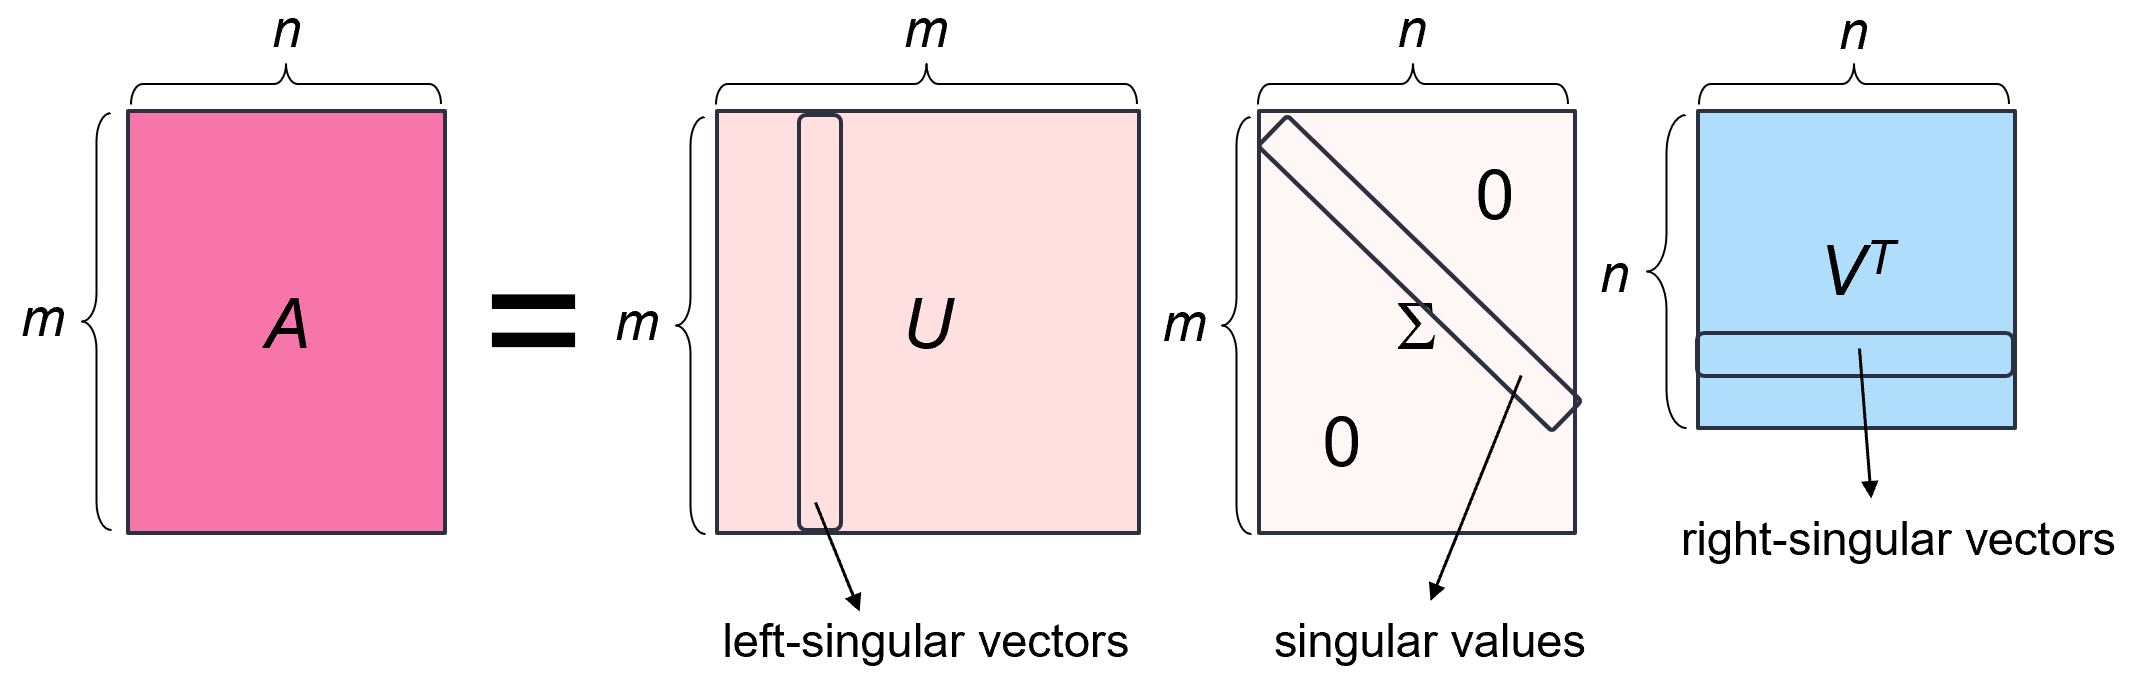

In [6]:
display(HTML(images_html[3]))


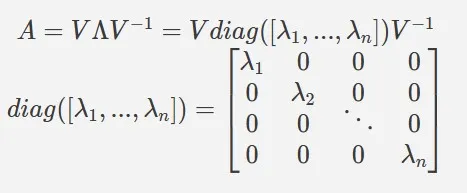

In [7]:
display(HTML(images_html[4]))


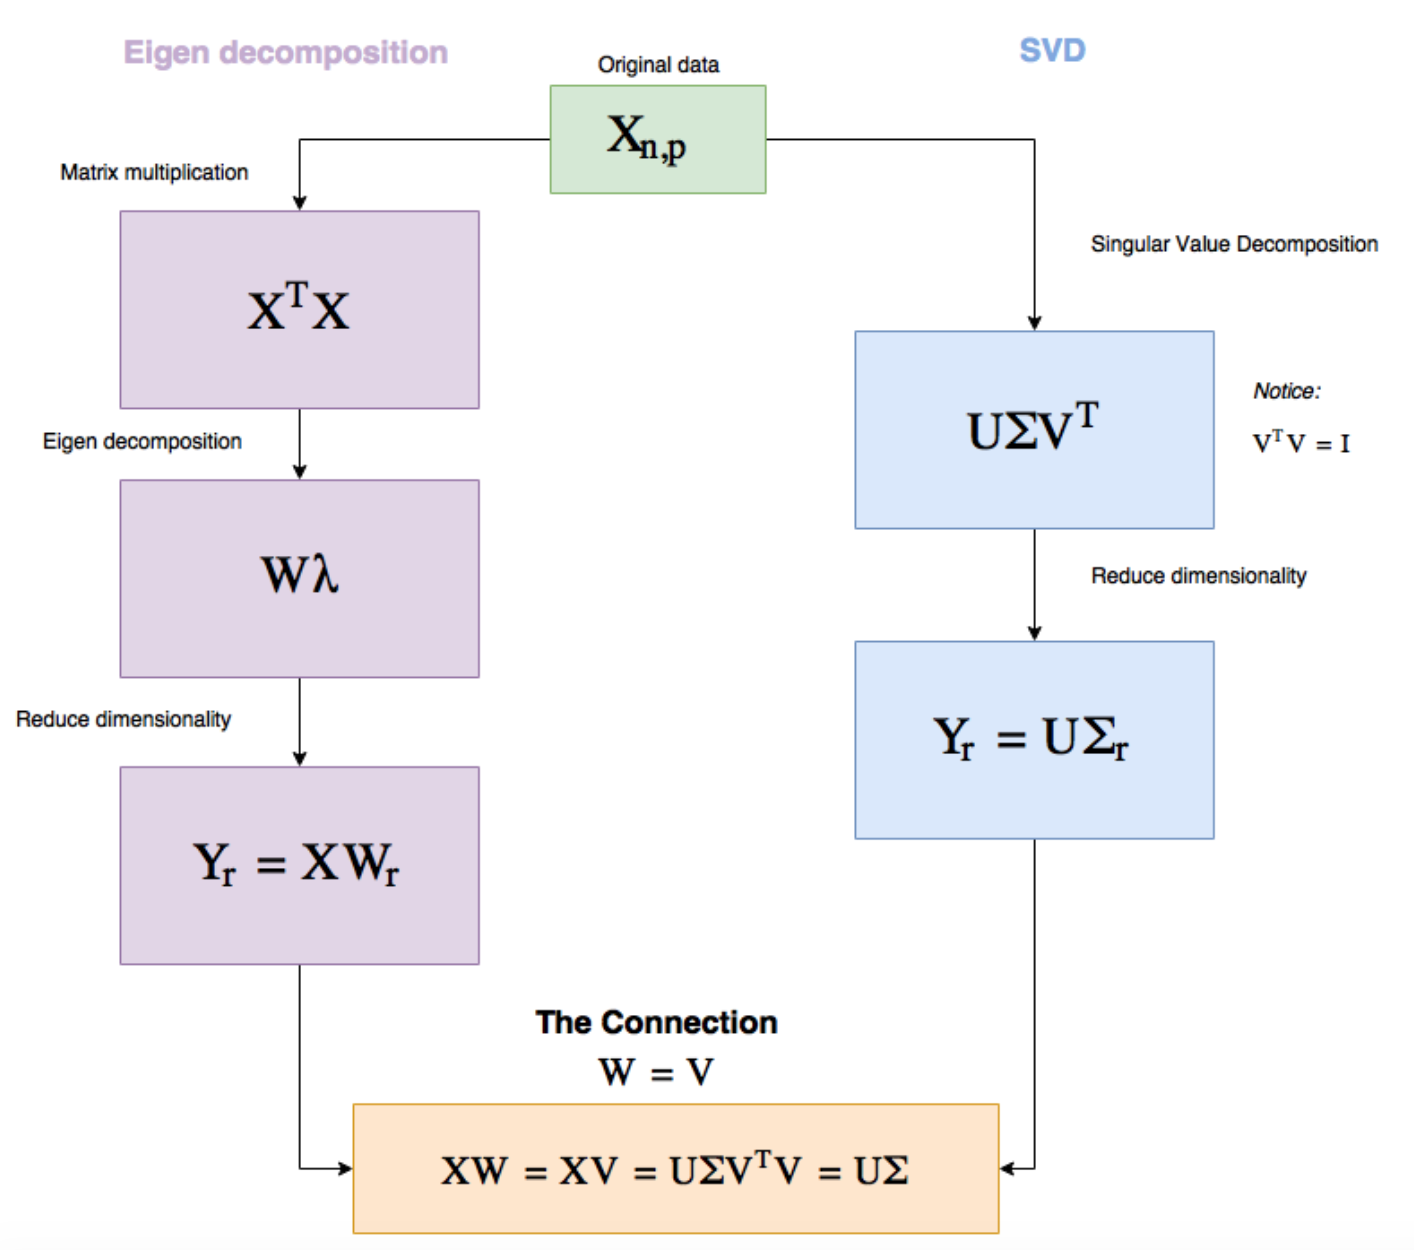

In [8]:
display(HTML(images_html[5]))

#### Load the dataset

In [2]:
try:
    weather_df = pd.read_csv('weatherHistory.csv')
    
except FileNotFoundError:
    print("Please make sure the file is in your current directory.")
    
print(f"\Dataset Shape: {weather_df.shape}")
print(f"   - Rows (observations): {weather_df.shape[0]:,}")
print(f"   - Columns (features): {weather_df.shape[1]}")

print("\n🔍 First 5 rows of the dataset:")
print(weather_df.head())

print("\nColumn names and data types:")
print(weather_df.dtypes)


\Dataset Shape: (96453, 12)
   - Rows (observations): 96,453
   - Columns (features): 12

🔍 First 5 rows of the dataset:
                  Formatted Date        Summary Precip Type  Temperature (C)  \
0  2006-04-01 00:00:00.000 +0200  Partly Cloudy        rain         9.472222   
1  2006-04-01 01:00:00.000 +0200  Partly Cloudy        rain         9.355556   
2  2006-04-01 02:00:00.000 +0200  Mostly Cloudy        rain         9.377778   
3  2006-04-01 03:00:00.000 +0200  Partly Cloudy        rain         8.288889   
4  2006-04-01 04:00:00.000 +0200  Mostly Cloudy        rain         8.755556   

   Apparent Temperature (C)  Humidity  Wind Speed (km/h)  \
0                  7.388889      0.89            14.1197   
1                  7.227778      0.86            14.2646   
2                  9.377778      0.89             3.9284   
3                  5.944444      0.83            14.1036   
4                  6.977778      0.83            11.0446   

   Wind Bearing (degrees)  Visibility

#### Exploratory Data Analysis



Missing Values Analysis:
             Missing Count  Missing Percentage
Precip Type            517                0.54

Summary Statistics:
       Temperature (C)  Apparent Temperature (C)  Humidity  Wind Speed (km/h)  \
count         96453.00                  96453.00  96453.00           96453.00   
mean             11.93                     10.86      0.73              10.81   
std               9.55                     10.70      0.20               6.91   
min             -21.82                    -27.72      0.00               0.00   
25%               4.69                      2.31      0.60               5.83   
50%              12.00                     12.00      0.78               9.97   
75%              18.84                     18.84      0.89              14.14   
max              39.91                     39.34      1.00              63.85   

       Wind Bearing (degrees)  Visibility (km)  Loud Cover  \
count                96453.00         96453.00     96453.0   
mean 

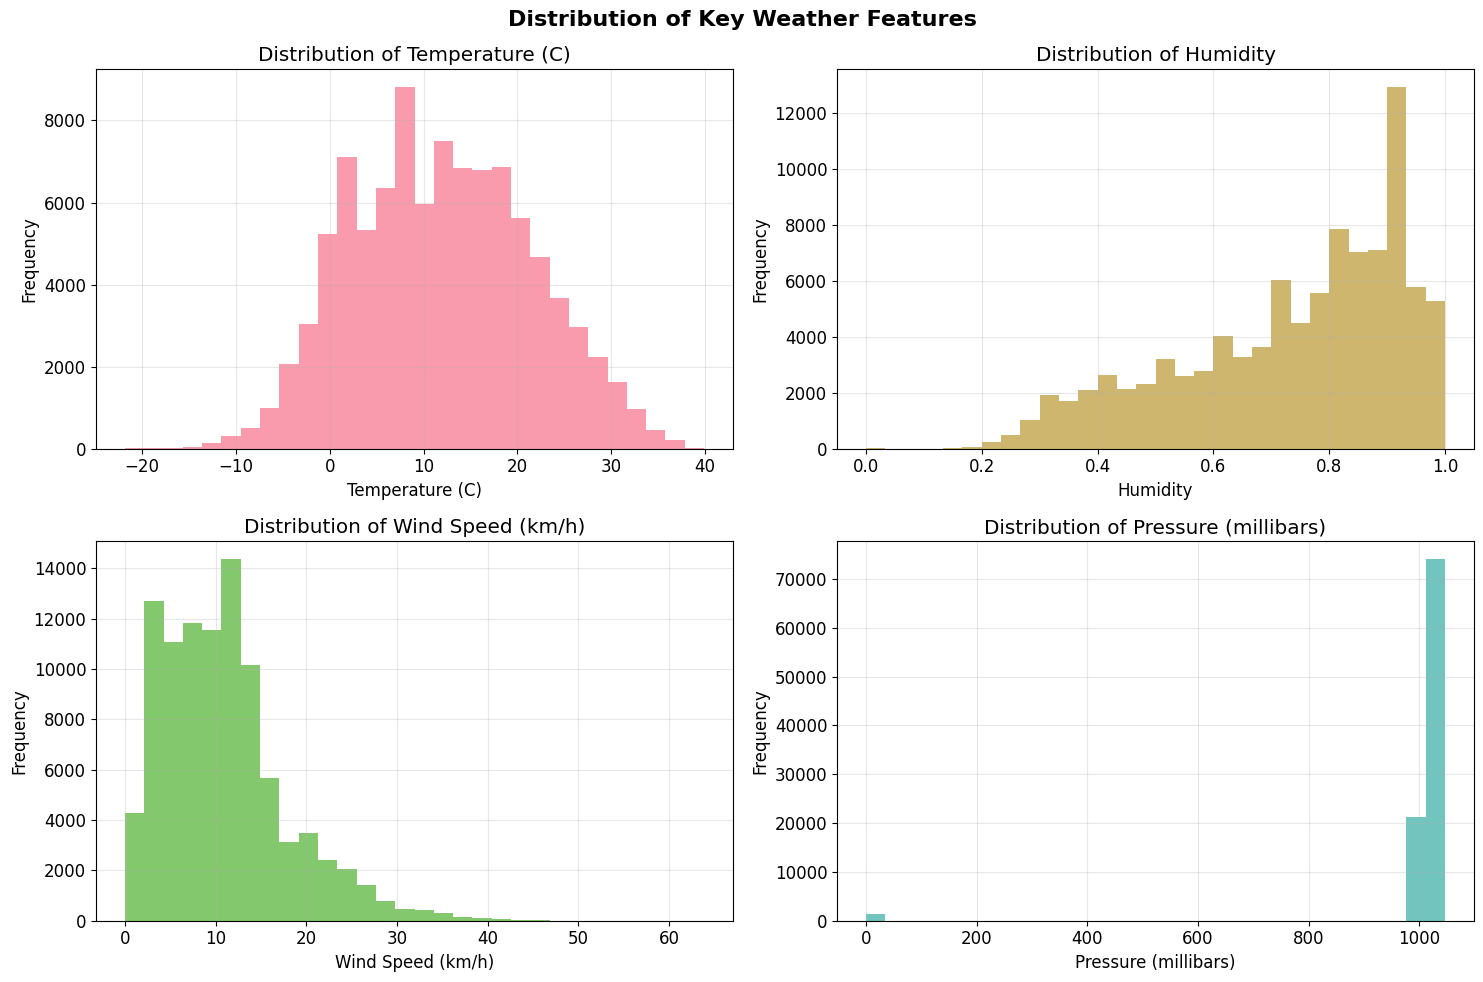


Data exploration complete!
   - Dataset contains 8 numerical features
   - Ready for preprocessing and PCA analysis


In [3]:
# Comprehensive data exploration to understand our weather dataset
print("\nMissing Values Analysis:")
missing_values = weather_df.isnull().sum()
missing_percentage = (missing_values / len(weather_df)) * 100

missing_info = pd.DataFrame({
    'Missing Count': missing_values,
    'Missing Percentage': missing_percentage.round(2)
})
print(missing_info[missing_info['Missing Count'] > 0])

# Display summary statistics for numerical columns
print("\nSummary Statistics:")
numerical_columns = weather_df.select_dtypes(include=[np.number]).columns
print(weather_df[numerical_columns].describe().round(2))

# Create visualizations to understand data distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Distribution of Key Weather Features', fontsize=16, fontweight='bold')

# Plot histograms for key weather variables
key_features = ['Temperature (C)', 'Humidity', 'Wind Speed (km/h)', 'Pressure (millibars)']

for i, feature in enumerate(key_features):
    if feature in weather_df.columns:
        row = i // 2
        col = i % 2
        
        # Create histogram
        axes[row, col].hist(weather_df[feature].dropna(), bins=30, alpha=0.7, color=sns.color_palette()[i])
        axes[row, col].set_title(f'Distribution of {feature}')
        axes[row, col].set_xlabel(feature)
        axes[row, col].set_ylabel('Frequency')
        axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nData exploration complete!")
print(f"   - Dataset contains {len(numerical_columns)} numerical features")
print(f"   - Ready for preprocessing and PCA analysis")


#### Data preprocessing: preparing the dataset for PCA analysis


In [15]:
# Get all numerical columns
numerical_cols = weather_df.select_dtypes(include=[np.number]).columns.tolist()
print(f"   Found {len(numerical_cols)} numerical columns: {numerical_cols}")

# Remove any ID or index columns if they exist
columns_to_exclude = ['Unnamed: 0', 'index']  # Common unwanted columns
numerical_cols = [col for col in numerical_cols if col not in columns_to_exclude]

# Create a subset with only numerical features
weather_numerical = weather_df[numerical_cols].copy()
print(f"   Selected {len(numerical_cols)} features for PCA")

missing_before = weather_numerical.isnull().sum().sum()
print(f"   Missing values before cleaning: {missing_before}")

if missing_before > 0:
    # Use median imputation for missing values (robust to outliers)
    imputer = SimpleImputer(strategy='median')
    weather_numerical_imputed = pd.DataFrame(
        imputer.fit_transform(weather_numerical),
        columns=weather_numerical.columns,
        index=weather_numerical.index
    )
    weather_numerical = weather_numerical_imputed
    print(f"Missing values imputed using median strategy")
else:
    print(f"No missing values found")


# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the data
weather_scaled = scaler.fit_transform(weather_numerical)

# Convert back to DataFrame for easier handling
weather_scaled_df = pd.DataFrame(
    weather_scaled, 
    columns=weather_numerical.columns,
    index=weather_numerical.index
)

print(f"  Features standardized (mean=0, std=1)")

# Display preprocessing results
print(f"\ Preprocessing Summary:")
print(f"   - Original shape: {weather_df.shape}")
print(f"   - Processed shape: {weather_scaled_df.shape}")
print(f"   - Features for PCA: {list(weather_scaled_df.columns)}")

# Show before/after statistics
print(f"\n Standardization Results:")
print("Before standardization (original data):")
print(weather_numerical.describe().round(2))
print("\nAfter standardization (mean ≈ 0, std ≈ 1):")
print(weather_scaled_df.describe().round(2))


   Found 8 numerical columns: ['Temperature (C)', 'Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)', 'Wind Bearing (degrees)', 'Visibility (km)', 'Loud Cover', 'Pressure (millibars)']
   Selected 8 features for PCA
   Missing values before cleaning: 0
No missing values found
  Features standardized (mean=0, std=1)
\ Preprocessing Summary:
   - Original shape: (96453, 12)
   - Processed shape: (96453, 8)
   - Features for PCA: ['Temperature (C)', 'Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)', 'Wind Bearing (degrees)', 'Visibility (km)', 'Loud Cover', 'Pressure (millibars)']

 Standardization Results:
Before standardization (original data):
       Temperature (C)  Apparent Temperature (C)  Humidity  Wind Speed (km/h)  \
count         96453.00                  96453.00  96453.00           96453.00   
mean             11.93                     10.86      0.73              10.81   
std               9.55                     10.70      0.20               6.91   
min  

In [14]:
# Apply Principal Component Analysis to the standardized weather data

# Initialize PCA with 2 components for visualization
print("\nInitializing PCA...")
n_components = 2  # Start with 2 components for 2D visualization
pca = PCA(n_components=n_components, random_state=42)
print(f"   PCA initialized with {n_components} components")

# Fit PCA to the standardized data
print("\nFitting PCA to the data...")
pca_result = pca.fit_transform(weather_scaled_df)
print(f"  PCA transformation complete")
print(f"   Original dimensions: {weather_scaled_df.shape[1]} features")
print(f"   Reduced dimensions: {pca_result.shape[1]} components")

# Analyze explained variance
print("\n Analyzing explained variance...")
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

print(f"   PC1 explains: {explained_variance_ratio[0]:.1%} of total variance")
print(f"   PC2 explains: {explained_variance_ratio[1]:.1%} of total variance")
print(f"   Total explained: {cumulative_variance[1]:.1%} of total variance")

# Create DataFrame with PCA results
pca_df = pd.DataFrame(
    pca_result,
    columns=[f'PC{i+1}' for i in range(n_components)],
    index=weather_scaled_df.index
)

# Add original features for reference (optional - just a few key ones)
if 'Temperature (C)' in weather_df.columns:
    pca_df['Temperature'] = weather_df['Temperature (C)'].values
if 'Humidity' in weather_df.columns:
    pca_df['Humidity'] = weather_df['Humidity'].values

print(f"\n PCA Results Preview:")
print(pca_df.head())

# Display component loadings (feature contributions)
print(f"\n Feature Contributions to Principal Components:")
components_df = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(n_components)],
    index=weather_scaled_df.columns
)
print(components_df.round(3))

print(f"\nPCA analysis complete!")
print(f"   - Reduced {weather_scaled_df.shape[1]} features to {n_components} components")
print(f"   - Captured {cumulative_variance[1]:.1%} of total variance")



Initializing PCA...
   PCA initialized with 2 components

Fitting PCA to the data...
  PCA transformation complete
   Original dimensions: 8 features
   Reduced dimensions: 2 components

 Analyzing explained variance...
   PC1 explains: 39.4% of total variance
   PC2 explains: 16.5% of total variance
   Total explained: 55.9% of total variance

 PCA Results Preview:
        PC1       PC2  Temperature  Humidity
0 -0.193205  0.781919     9.472222      0.89
1 -0.131097  0.861931     9.355556      0.86
2 -0.282776 -0.637340     9.377778      0.89
3 -0.186826  0.949487     8.288889      0.83
4 -0.138043  0.536315     8.755556      0.83

 Feature Contributions to Principal Components:
                            PC1    PC2
Temperature (C)           0.569 -0.134
Apparent Temperature (C)  0.561 -0.184
Humidity                 -0.480 -0.146
Wind Speed (km/h)         0.068  0.771
Wind Bearing (degrees)    0.032  0.512
Visibility (km)           0.355  0.119
Loud Cover               -0.000  0.000

#### Visualisation of PCA


 Creating basic PCA scatter plot...
 Creating temperature-colored PCA plot...


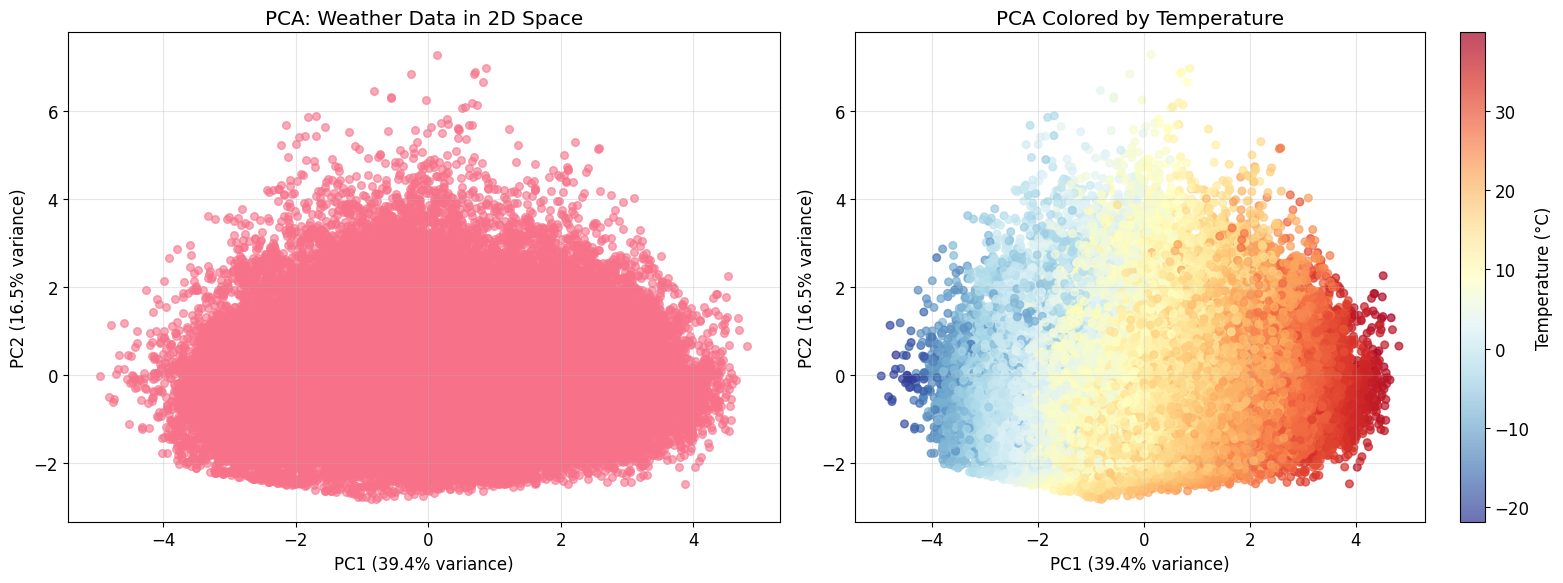


 Analyzing data distribution in PC space...


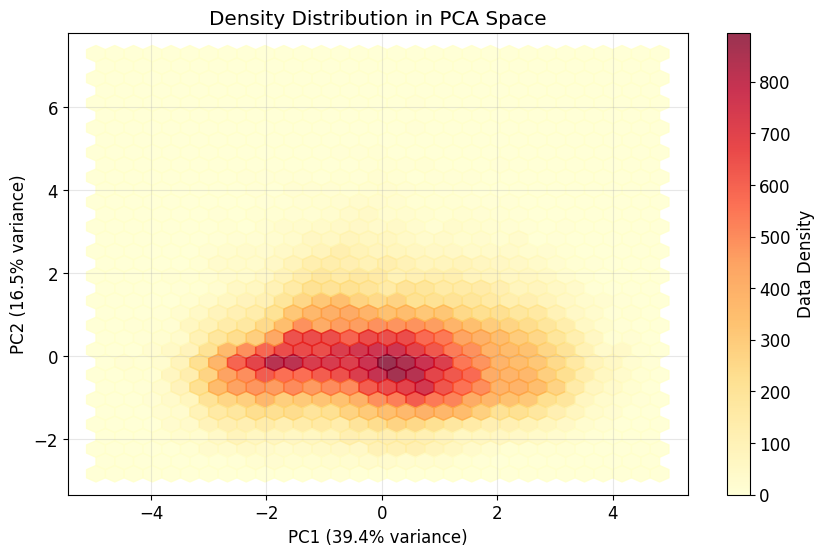


 Interpretation Tips:
   - Points close together have similar weather patterns
   - PC1 captures the most important weather variation (39.4%)
   - PC2 captures the second most important variation (16.5%)
   - Color patterns reveal how temperature/humidity relates to the main weather components


In [13]:
# Create a comprehensive PCA visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Basic PCA scatter plot
print("\n Creating basic PCA scatter plot...")
axes[0].scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.6, s=30)
axes[0].set_xlabel(f'PC1 ({explained_variance_ratio[0]:.1%} variance)')
axes[0].set_ylabel(f'PC2 ({explained_variance_ratio[1]:.1%} variance)')
axes[0].set_title('PCA: Weather Data in 2D Space')
axes[0].grid(True, alpha=0.3)

# Plot 2: Color-coded by temperature (if available)
print(" Creating temperature-colored PCA plot...")
if 'Temperature' in pca_df.columns:
    scatter = axes[1].scatter(
        pca_df['PC1'], 
        pca_df['PC2'], 
        c=pca_df['Temperature'], 
        cmap='RdYlBu_r',  # Red-Yellow-Blue colormap (reversed)
        alpha=0.7, 
        s=30
    )
    axes[1].set_xlabel(f'PC1 ({explained_variance_ratio[0]:.1%} variance)')
    axes[1].set_ylabel(f'PC2 ({explained_variance_ratio[1]:.1%} variance)')
    axes[1].set_title('PCA Colored by Temperature')
    axes[1].grid(True, alpha=0.3)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=axes[1])
    cbar.set_label('Temperature (°C)')
else:
    # If temperature not available, color by humidity or another feature
    if 'Humidity' in pca_df.columns:
        scatter = axes[1].scatter(
            pca_df['PC1'], 
            pca_df['PC2'], 
            c=pca_df['Humidity'], 
            cmap='Blues',
            alpha=0.7, 
            s=30
        )
        axes[1].set_xlabel(f'PC1 ({explained_variance_ratio[0]:.1%} variance)')
        axes[1].set_ylabel(f'PC2 ({explained_variance_ratio[1]:.1%} variance)')
        axes[1].set_title('PCA Colored by Humidity')
        axes[1].grid(True, alpha=0.3)
        
        cbar = plt.colorbar(scatter, ax=axes[1])
        cbar.set_label('Humidity')

plt.tight_layout()
plt.show()

# Additional insight: Show data distribution in PC space
print("\n Analyzing data distribution in PC space...")
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Create density plot
ax.hexbin(pca_df['PC1'], pca_df['PC2'], gridsize=30, cmap='YlOrRd', alpha=0.8)
ax.set_xlabel(f'PC1 ({explained_variance_ratio[0]:.1%} variance)')
ax.set_ylabel(f'PC2 ({explained_variance_ratio[1]:.1%} variance)')
ax.set_title('Density Distribution in PCA Space')
ax.grid(True, alpha=0.3)

plt.colorbar(ax.collections[0], label='Data Density')
plt.show()

print(f"\n Interpretation Tips:")
print(f"   - Points close together have similar weather patterns")
print(f"   - PC1 captures the most important weather variation ({explained_variance_ratio[0]:.1%})")
print(f"   - PC2 captures the second most important variation ({explained_variance_ratio[1]:.1%})")
print(f"   - Color patterns reveal how temperature/humidity relates to the main weather components")


#### Create a scree plot to determine optimal number of components


Computing PCA with all components...
  Computed PCA for all 8 components

 Creating scree plot visualization...


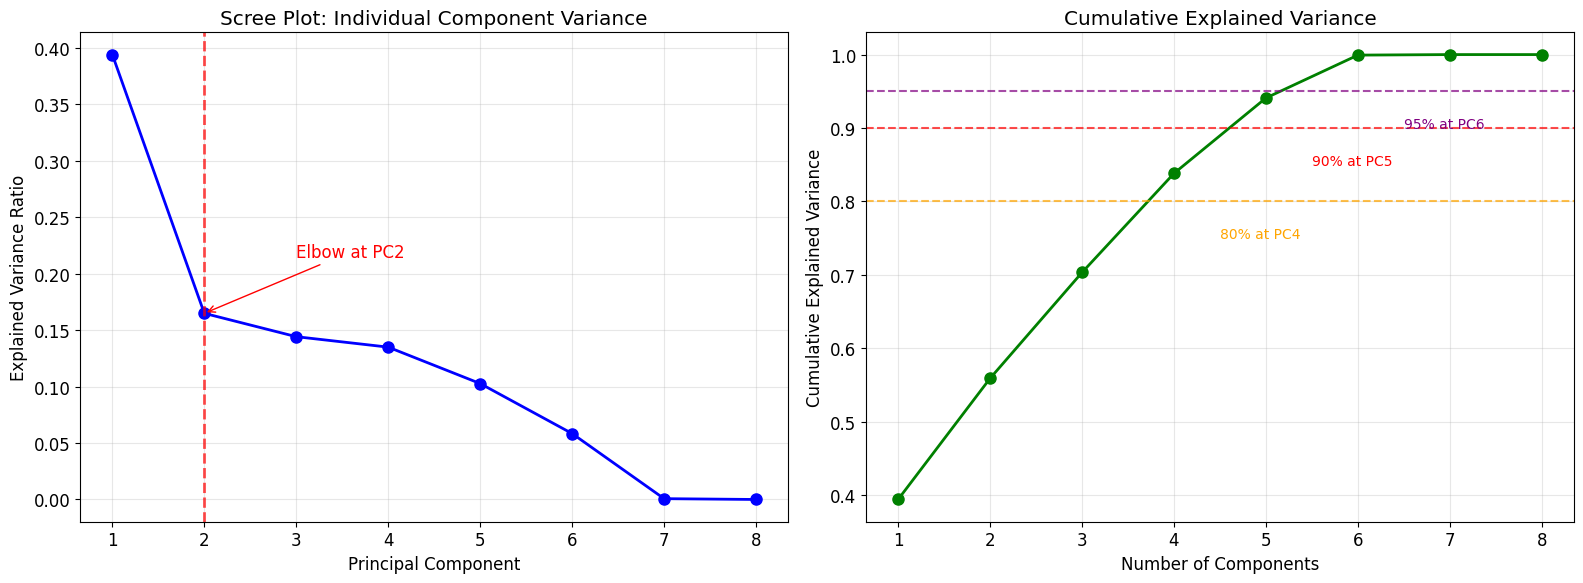


 COMPONENT SELECTION RECOMMENDATIONS:
    80% variance: 4 components
    90% variance: 5 components
    95% variance: 6 components

Detailed Variance Analysis:
   PC1: 39.4% individual, 39.4% cumulative
   PC2: 16.5% individual, 55.9% cumulative
   PC3: 14.4% individual, 70.3% cumulative
   PC4: 13.5% individual, 83.8% cumulative
   PC5: 10.3% individual, 94.1% cumulative


In [12]:
#Perform PCA with all possible components
print("\nComputing PCA with all components...")
n_features = weather_scaled_df.shape[1]
pca_full = PCA(random_state=42)  # Use all components
pca_full.fit(weather_scaled_df)

# Get explained variance ratios for all components
explained_variance_all = pca_full.explained_variance_ratio_
cumulative_variance_all = np.cumsum(explained_variance_all)

print(f"  Computed PCA for all {n_features} components")

# Create the scree plot
print("\n Creating scree plot visualization...")
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Individual explained variance (Scree Plot)
component_numbers = range(1, len(explained_variance_all) + 1)
axes[0].plot(component_numbers, explained_variance_all, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title('Scree Plot: Individual Component Variance')
axes[0].grid(True, alpha=0.3)

# Highlight the "elbow" point (where slope changes dramatically)
# Find the elbow using the difference in slopes
if len(explained_variance_all) > 2:
    differences = np.diff(explained_variance_all)
    second_differences = np.diff(differences)
    elbow_point = np.argmax(second_differences) + 2  # +2 because of double diff
    
    axes[0].axvline(x=elbow_point, color='red', linestyle='--', alpha=0.7, linewidth=2)
    axes[0].annotate(f'Elbow at PC{elbow_point}', 
                    xy=(elbow_point, explained_variance_all[elbow_point-1]), 
                    xytext=(elbow_point+1, explained_variance_all[elbow_point-1]+0.05),
                    arrowprops=dict(arrowstyle='->', color='red'),
                    fontsize=12, color='red')

# Plot 2: Cumulative explained variance
axes[1].plot(component_numbers, cumulative_variance_all, 'go-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Explained Variance')
axes[1].set_title('Cumulative Explained Variance')
axes[1].grid(True, alpha=0.3)

# Add horizontal lines for common thresholds
thresholds = [0.8, 0.9, 0.95]
colors = ['orange', 'red', 'purple']
for threshold, color in zip(thresholds, colors):
    axes[1].axhline(y=threshold, color=color, linestyle='--', alpha=0.7)
    # Find how many components needed for this threshold
    components_needed = np.argmax(cumulative_variance_all >= threshold) + 1
    axes[1].annotate(f'{threshold:.0%} at PC{components_needed}', 
                    xy=(components_needed, threshold), 
                    xytext=(components_needed+0.5, threshold-0.05),
                    fontsize=10, color=color)

plt.tight_layout()
plt.show()

# Step 3: Provide recommendations
print(f"\n COMPONENT SELECTION RECOMMENDATIONS:")
print(f"=" * 50)

# Find components for different variance thresholds
for threshold in [0.8, 0.9, 0.95]:
    components_needed = np.argmax(cumulative_variance_all >= threshold) + 1
    print(f"    {threshold:.0%} variance: {components_needed} components")

print(f"\nDetailed Variance Analysis:")
for i in range(min(5, len(explained_variance_all))):  # Show first 5 components
    print(f"   PC{i+1}: {explained_variance_all[i]:.1%} individual, {cumulative_variance_all[i]:.1%} cumulative")


#### Recommendation:
- For most analyses: Use 4 components (captures 80% variance)
- For visualization: Use 2-3 components
- For high precision: Use 6 components (95% variance)

####  Analyze which original features contribute most to each principal component


   Component loadings for top 2 components:
                            PC1    PC2
Temperature (C)           0.569 -0.134
Apparent Temperature (C)  0.561 -0.184
Humidity                 -0.480 -0.146
Wind Speed (km/h)         0.068  0.771
Wind Bearing (degrees)    0.032  0.512
Visibility (km)           0.355  0.119
Loud Cover               -0.000  0.000
Pressure (millibars)      0.007 -0.239

 Top contributing features for each component:

 PC1 (explains 39.4% of variance):
      1. Temperature (C): 0.569 (contributes positively)
      2. Apparent Temperature (C): 0.561 (contributes positively)
      3. Humidity: -0.480 (contributes negatively)

 PC2 (explains 16.5% of variance):
      1. Wind Speed (km/h): 0.771 (contributes positively)
      2. Wind Bearing (degrees): 0.512 (contributes positively)
      3. Pressure (millibars): -0.239 (contributes negatively)

 Creating feature contribution visualizations...


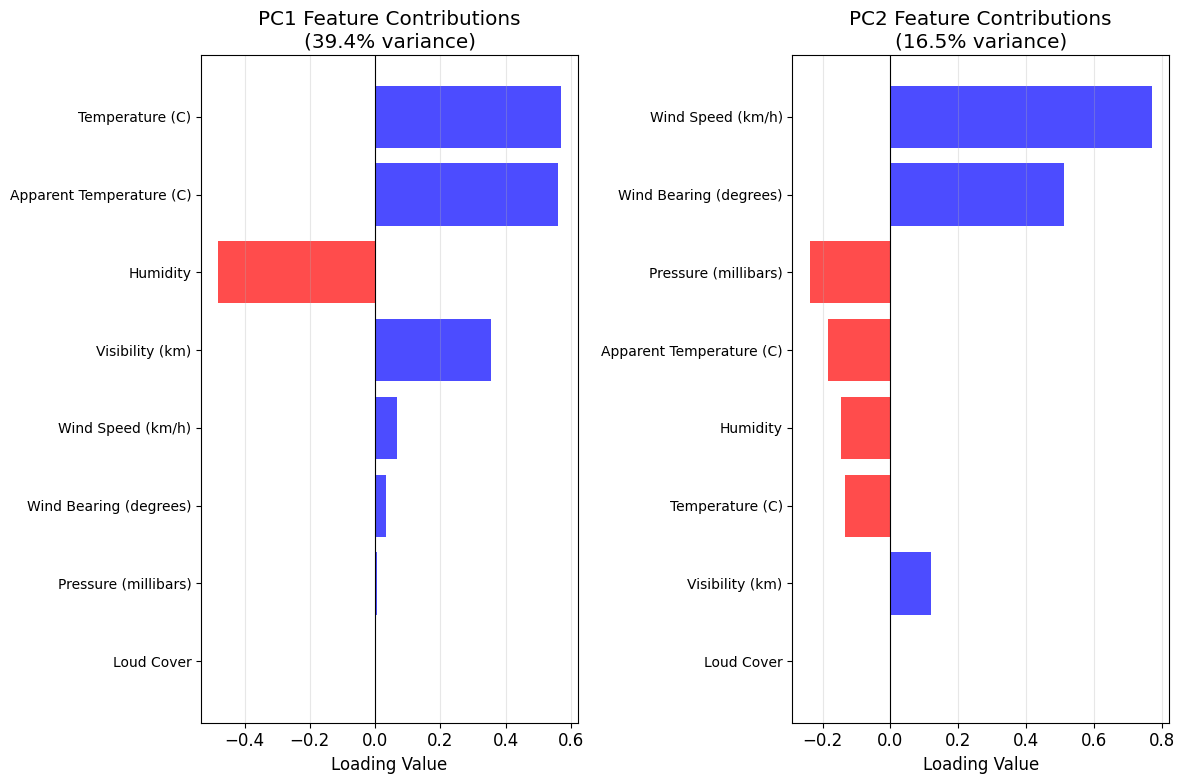


 Creating feature contribution heatmap...


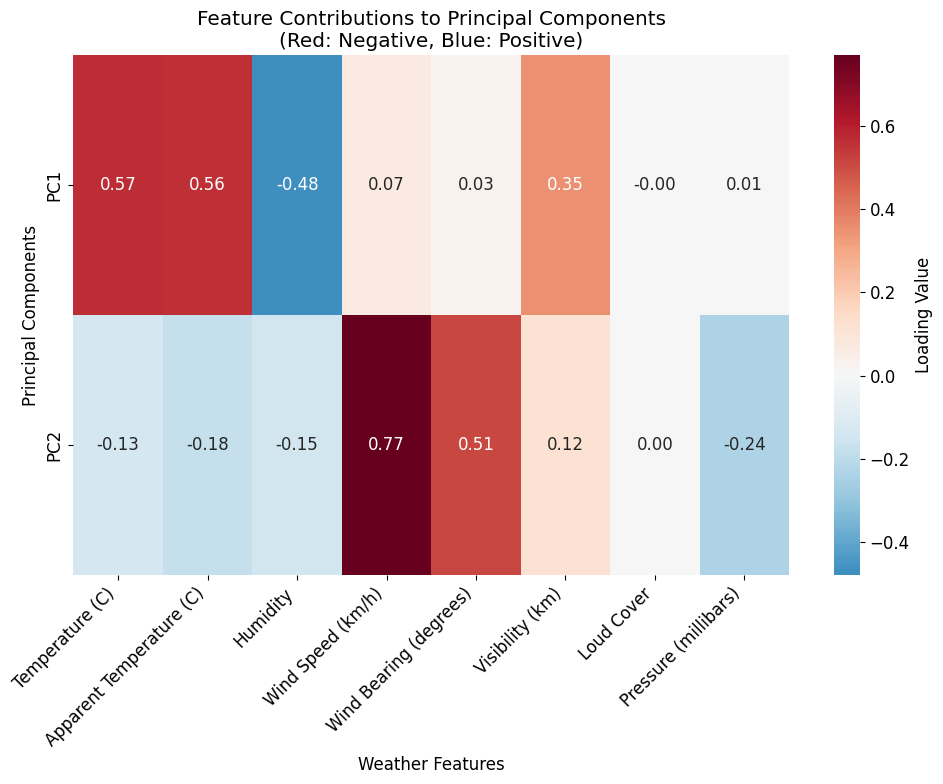


 INTERPRETATION GUIDE:
    Loading Values:
      • Positive loading: Feature increases with the component
      • Negative loading: Feature decreases with the component
      • Larger absolute value: Stronger contribution

     Weather Pattern Insights:
      • PC1: Likely represents weather patterns involving Temperature (C), Apparent Temperature (C)
      • PC2: Likely represents weather patterns involving Wind Speed (km/h), Wind Bearing (degrees)

Feature analysis complete!


In [10]:
# Get the component loadings (how much each feature contributes to each PC)
feature_names = weather_scaled_df.columns
n_components_to_analyze = min(3, pca.n_components_)  # Analyze up to 3 components

# Create a detailed components DataFrame
components_detailed = pd.DataFrame(
    pca.components_[:n_components_to_analyze].T,
    columns=[f'PC{i+1}' for i in range(n_components_to_analyze)],
    index=feature_names
)

print(f"   Component loadings for top {n_components_to_analyze} components:")
print(components_detailed.round(3))

# Identify top contributing features for each component
print(f"\n Top contributing features for each component:")

top_features_per_component = {}
for i in range(n_components_to_analyze):
    pc_name = f'PC{i+1}'
    
    # Get absolute values to find strongest contributors (positive or negative)
    abs_loadings = np.abs(components_detailed[pc_name])
    top_features = abs_loadings.nlargest(3)  # Top 3 contributors
    
    print(f"\n {pc_name} (explains {explained_variance_ratio[i]:.1%} of variance):")
    for j, (feature, loading) in enumerate(top_features.items()):
        original_loading = components_detailed.loc[feature, pc_name]
        direction = "positively" if original_loading > 0 else "negatively"
        print(f"      {j+1}. {feature}: {original_loading:.3f} (contributes {direction})")
    
    top_features_per_component[pc_name] = top_features.index.tolist()

# Create visualization of feature contributions
print(f"\n Creating feature contribution visualizations...")

fig, axes = plt.subplots(1, n_components_to_analyze, figsize=(6*n_components_to_analyze, 8))
if n_components_to_analyze == 1:
    axes = [axes]  # Make it iterable for single component

for i in range(n_components_to_analyze):
    pc_name = f'PC{i+1}'
    
    # Get loadings for this component
    loadings = components_detailed[pc_name].sort_values(key=abs, ascending=True)
    
    # Create horizontal bar plot
    colors = ['red' if x < 0 else 'blue' for x in loadings.values]
    bars = axes[i].barh(range(len(loadings)), loadings.values, color=colors, alpha=0.7)
    
    # Customize the plot
    axes[i].set_yticks(range(len(loadings)))
    axes[i].set_yticklabels(loadings.index, fontsize=10)
    axes[i].set_xlabel('Loading Value')
    axes[i].set_title(f'{pc_name} Feature Contributions\n({explained_variance_ratio[i]:.1%} variance)')
    axes[i].grid(True, alpha=0.3, axis='x')
    axes[i].axvline(x=0, color='black', linewidth=0.8)

plt.tight_layout()
plt.show()

# Create a summary heatmap
print(f"\n Creating feature contribution heatmap...")

plt.figure(figsize=(10, 8))
sns.heatmap(components_detailed.T, 
            annot=True, 
            cmap='RdBu_r', 
            center=0, 
            fmt='.2f',
            cbar_kws={'label': 'Loading Value'})
plt.title('Feature Contributions to Principal Components\n(Red: Negative, Blue: Positive)')
plt.xlabel('Weather Features')
plt.ylabel('Principal Components')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Interpret the biological/physical meaning
print(f"\n INTERPRETATION GUIDE:")
print(f"=" * 50)
print(f"    Loading Values:")
print(f"      • Positive loading: Feature increases with the component")
print(f"      • Negative loading: Feature decreases with the component")
print(f"      • Larger absolute value: Stronger contribution")
print(f"\n     Weather Pattern Insights:")
for i, pc_name in enumerate([f'PC{i+1}' for i in range(n_components_to_analyze)]):
    print(f"      • {pc_name}: Likely represents weather patterns involving {', '.join(top_features_per_component[pc_name][:2])}")

print(f"\nFeature analysis complete!")
